<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=left> Understanding Deepfakes with Keras</h2>
<img align=center src="DCGAN.png"></img>

### Task 1: Importing Libraries and Helper Functions
Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image
import pandas as pd

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.10.0


### Task 2: Importing and Plotting the Data

In [4]:
(x_train,y_train),(x_test,y_test)=tfutils.datasets.mnist.load_data(one_hot=False)
#word with just the zeros 

x_train=tfutils.datasets.mnist.load_subset([0],x_train,y_train)

x_test=tfutils.datasets.mnist.load_subset([0],x_test,y_test)

x=np.concatenate([x_train,x_test],axis=0)

<IPython.core.display.Javascript object>


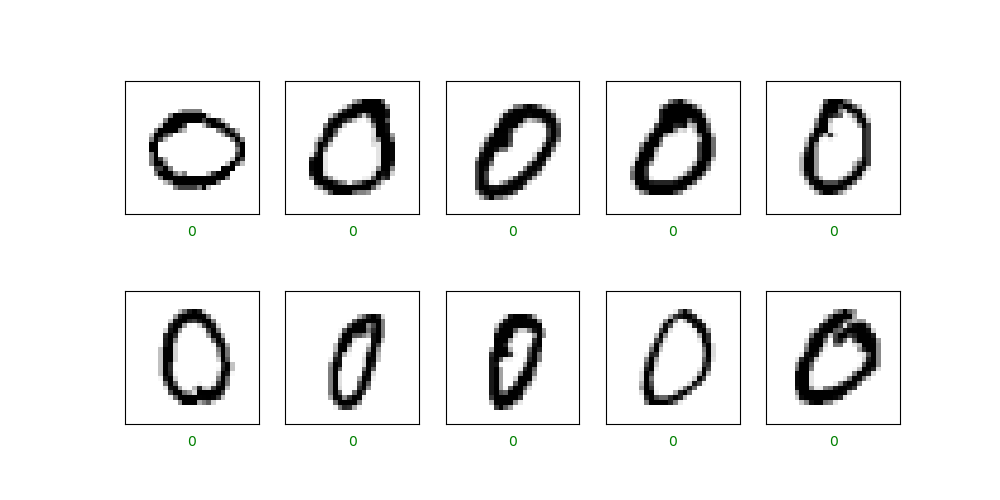

In [5]:
tfutils.datasets.mnist.plot_ten_random_examples(plt,x,np.zeros((x.shape[0],1))).show()

<h2 align=left> Task 3: Discriminatore </h2>
<img align=center src="artist_critic.png"></img>

In [10]:
#generative adversarial #generator artist #discrimantor critic
#when it is noise easier for discrimantor to find the fake one but after training generator gets better 
#after training generator better at generating critic better at criticizing 
discriminator=Sequential([
    Conv2D(64,3,strides=2,input_shape=(28,28,1)),
    LeakyReLU(),
    BatchNormalization(),
    #inspired by the original paper convention in neural network to use power of 2 
    Conv2D(128,5,strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256,5,strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1,activation='sigmoid')
    
])


opt=tf.keras.optimizers.Adam(lr=2e-4,beta_1=0.5)
discriminator.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
discriminator.summary()
#tensorflow back end is going to load the CUDA library little bit of time 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        640       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 13, 13, 64)        0         
                                                                 
 batch_normalization_9 (Batc  (None, 13, 13, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 5, 5, 128)         0         
                                                                 
 batch_normalization_10 (Bat  (None, 5, 5, 128)        512       
 chNormalization)                                     

<h2 align=left> Task 4: Generator </h2>

In [12]:
generator=Sequential([
    Dense(256,activation='relu',input_shape=(1,)),
    #use a scalar instead of 128 dimensional vector to keep it simple
    Reshape((1,1,256)),
    
    Conv2DTranspose(256,5,activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128,5,activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64,5,strides=2,activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(32,5,activation='relu'),
    BatchNormalization(), 
    
    Conv2DTranspose(1,4,activation='sigmoid'),
    
    
])
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               512       
                                                                 
 reshape_1 (Reshape)         (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 5, 5, 256)        1638656   
 ranspose)                                                       
                                                                 
 batch_normalization_16 (Bat  (None, 5, 5, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 9, 9, 128)        819328    
 ranspose)                                                       
                                                      

1/1 [==============================] - 1s 1s/step


<IPython.core.display.Javascript object>


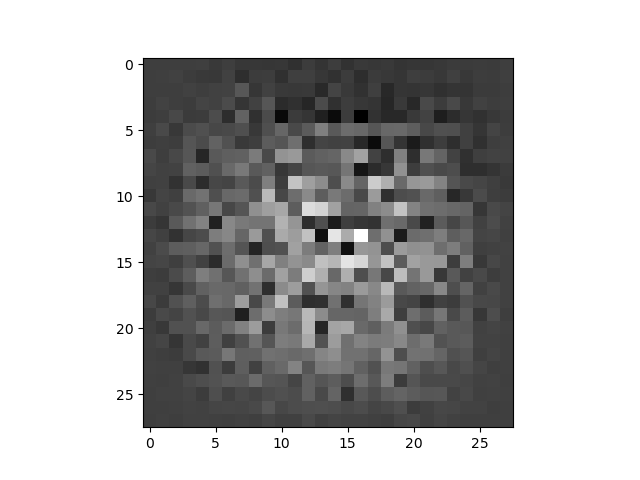

In [13]:
noise = np.random.randn(1,1)
gen_image=generator.predict(noise)[0]
plt.figure()
plt.imshow(np.reshape(gen_image,(28,28)),cmap='binary')
plt.show()


<h2 align=left> Task 5: Generative Adversarial Network (GAN) </h2>

In [15]:
#connect generator and disciminator 
input_layer=tf.keras.layers.Input(shape=(1,))
gen_out=generator(input_layer)
disc_out=discriminator(gen_out)
gan=Model(
input_layer,
disc_out)

discriminator.trainable=False
gan.compile(loss="binary_crossentropy",optimizer=opt,metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 1)         2717025   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 1027073   
                                                                 
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


<h2 align=left> Task 6 and 7: Training the GAN </h2>

In [18]:
epochs=25
batch_size=128
steps_per_epoch=int(2*x.shape[0]/batch_size)
print("step for epoch=",steps_per_epoch)


step for epoch= 107


<IPython.core.display.Javascript object>


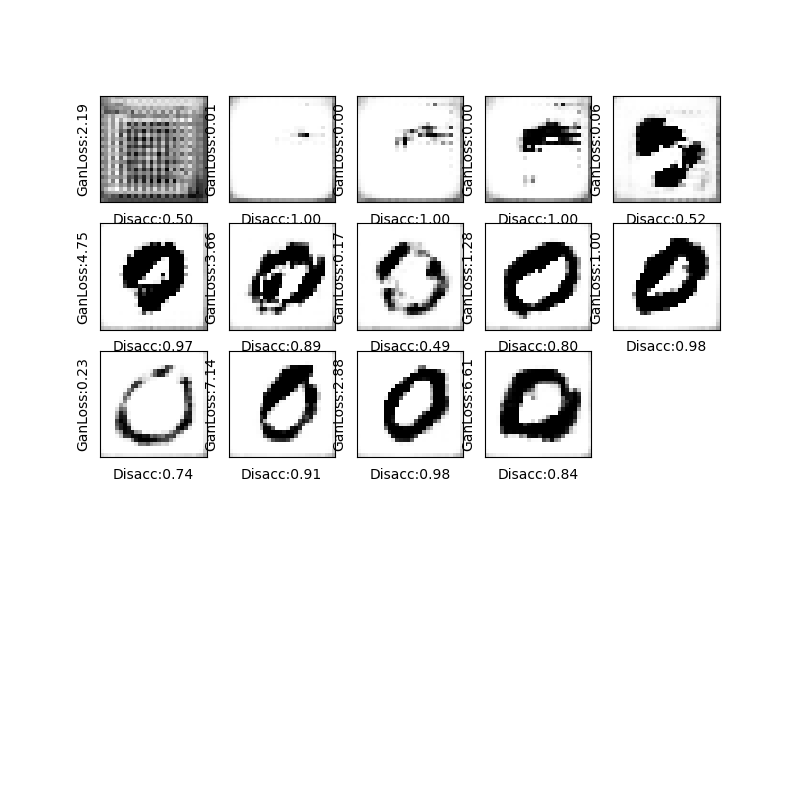

1/2 [==============>...............] - ETA: 0s

In [ ]:
dp=tfutils.plotting.DynamicPlot(plt,5,5,(8,8))
for e in range(0,epochs):
    dp.start_of_epoch(e)
    for step in range(0,steps_per_epoch):
        true_examples=x[int(batch_size/2)*step:int(batch_size/2)*(step+1)] #because half examples are true
        true_examples=np.reshape(true_examples,(true_examples.shape[0],28,28,1))
        
        noise = np.random.randn(int(batch_size/2),1)
        gen_examples=generator.predict(noise)
        
        x_batch=np.concatenate([gen_examples,true_examples],axis=0)
        y_batch=np.array([0]*int(batch_size/2)+[1]*int(batch_size/2))
        
        indices=np.random.choice(range(batch_size),batch_size,replace=False)
        x_batch=x_batch[indices]
        y_batch=y_batch[indices]
        
        discriminator.trainable=True
        discriminator.train_on_batch(x_batch,y_batch)
        discriminator.trainable=False
        
        
        loss,_=gan.train_on_batch(noise,np.ones((int(batch_size/2),1)))
        _,acc=discriminator.evaluate(x_batch,y_batch,verbose=False)
        #if high good job also performance of the generator  generator well dicrimantor reduces reversely same logic 
        
    noise =np.random.randn(1,1)
    gen_image=generator.predict(noise)[0]
    gen_image=np.reshape(gen_image,(28,28))
    dp.end_of_epoch(gen_image,'binary','Disacc:{:.2f}'.format(acc),'GanLoss:{:.2f}'.format(loss))

after each iteration discriminator learns to perform better as well as generator more epochs more it lean to do a better job  